# Functions (load data, plot simple)

In [2]:
import pandas as pd
import numpy as np
from numpy.linalg import svd, eig
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from sklearn.decomposition import PCA
from matplotlib.pyplot import imshow
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import (GradientBoostingRegressor, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              RandomForestClassifier,
                             RandomForestRegressor)
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# import sklearn.cross_validation as cv
import sklearn.model_selection as cv
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import log_loss, make_scorer, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error

import ndjson

plt.style.use('ggplot')

# %matplotlib inline
%matplotlib notebook

In [3]:
# load the npy and ndjson data
def load_data():
    faces = np.load('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/data/face.npy')
    eyes = np.load('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/data/eye.npy')
#     mouth = np.load('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/data/mouth.npy')
    noses = np.load('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/data/nose.npy')
    ears = np.load('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/data/ear.npy')
    
    # face
    with open('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/data_simplified/full_simplified_face.ndjson') as f:
        temp = ndjson.load(f)
    face_df = pd.DataFrame.from_dict(temp)
    
    # eye
    with open('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/data_simplified/full_simplified_eye.ndjson') as j:
        temp1 = ndjson.load(j)
    eye_df = pd.DataFrame.from_dict(temp1)
   
    # mouth
#     with open('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/data_simplified/full_simplified_mouth.ndjson') as k:
#         temp2 = ndjson.load(k)
#     mouth_df = pd.DataFrame.from_dict(temp2)
    
    # nose
    with open('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/data_simplified/full_simplified_nose.ndjson') as l:
        temp3 = ndjson.load(l)
    nose_df = pd.DataFrame.from_dict(temp3)
    
    # ear
    with open('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/data_simplified/full_simplified_ear.ndjson') as m:
        temp4 = ndjson.load(m)
    ear_df = pd.DataFrame.from_dict(temp4)
    
    print('loaded data')
    return faces, eyes, noses, ears, face_df, eye_df, nose_df, ear_df

In [4]:
# merge npy and ndjson data
def merge(df, npy):
    df['npy'] = list(npy)
    print('merged data')

In [5]:
# sampling only if it was recognized by the system
def sample_it(df, n):
    df_out = df[df['recognized'] == True].sample(n=n, replace=True)
    print('taken samples')
    return df_out

In [6]:
def clean_merge_it(df, df1):
    df = df.drop(['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp'], axis=1)
    df1 = df1.drop(['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp'], axis=1)
    print('clean and merged')
    return pd.concat([df, df1], join='inner', ignore_index=True)

In [7]:
# plots a 1x10 of an image

def plot_simple(data, name):
    fig, axs = plt.subplots(1,10, figsize=(10,1))

    for thing, ax in zip(data, axs.flatten()):
        image = thing.reshape(28, 28)
        ax.imshow(image, cmap=cm.Greys)
        ax.axis('off')
        
    fig.savefig('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/images/{}.png'.format(name), bbox_inches='tight')

In [8]:
def plot_stroke(data):
    fig, axes = plt.subplots(1,10, figsize=(10,1))
    axes = axes.ravel()

    for i, example in enumerate(data):
        if i == 10:
                break
        for x,y in example:
            axes[i].plot(x, y, marker='.')
            axes[i].axis('off')
#     plt.gca().invert_yaxis()

# plot_stroke(face_df['drawing'])

In [9]:
# load the data
faces, eyes, noses, ears, face_df, eye_df, nose_df, ear_df = load_data()

# merge the npy with df
merge(face_df, faces)
merge(eye_df, eyes)
# merge(mouth_df, mouth)
merge(nose_df, noses)
merge(ear_df, ears)

# sample subset of data
sample_face = sample_it(face_df, 5000)
sample_eye = sample_it(eye_df, 5000)
# sample_mouth = sample_it(mouth_df, 5000)
sample_nose = sample_it(nose_df, 5000)
sample_ear = sample_it(ear_df, 5000)

# merged sample and cleaned
df_a = clean_merge_it(sample_face, sample_eye)
# df_b = clean_merge_it(sample_mouth, sample_nose)
df_b = clean_merge_it(sample_nose, sample_ear)
df = pd.concat([df_a, df_b], join='inner', ignore_index=True)

# split npy to (20000,784)
df2 = pd.DataFrame(df.npy.tolist())

loaded data
merged data
merged data
merged data
merged data
taken samples
taken samples
taken samples
taken samples
clean and merged
clean and merged


In [10]:
df

,word,npy
0,face,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,face,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,face,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,face,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,face,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,face,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,face,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,face,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,face,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,face,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Plot True and False

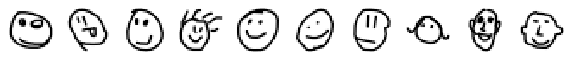

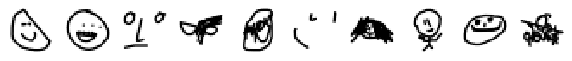

In [11]:
# plot true FACES
face_true = face_df[face_df['recognized'] == True]['npy']
plot_simple(face_true, 'row_true_faces')

# plot false FACES
face_false = face_df[face_df['recognized'] == False]['npy']
plot_simple(face_false, 'row_false_faces')

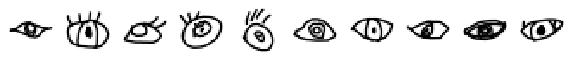

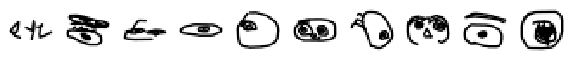

In [12]:
# plot true EYES
eye_true = eye_df[eye_df['recognized'] == True]['npy']
plot_simple(eye_true, 'row_true_eyes')

# plot false EYES
eye_false = eye_df[eye_df['recognized'] == False]['npy']
plot_simple(eye_false, 'row_false_eyes')

In [13]:
# # plot true MOUTH
# mouth_true = mouth_df[mouth_df['recognized'] == True]['npy']
# plot_simple(mouth_true, 'row_true_mouth')

# # plot false MOUTH
# mouth_false = mouth_df[mouth_df['recognized'] == False]['npy']
# plot_simple(mouth_false, 'row_false_mouth')

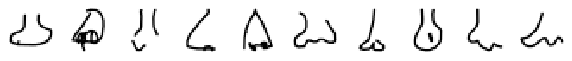

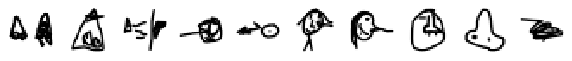

In [14]:
# plot true NOSE
nose_true = nose_df[nose_df['recognized'] == True]['npy']
plot_simple(nose_true, 'row_true_nose')

# plot false NOSE
nose_false = nose_df[nose_df['recognized'] == False]['npy']
plot_simple(nose_false, 'row_false_nose')

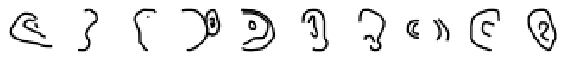

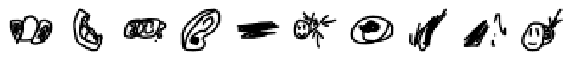

In [15]:
# plot true EAR
ear_true = ear_df[ear_df['recognized'] == True]['npy']
plot_simple(ear_true, 'row_true_ear')

# plot false EAR
ear_false = ear_df[ear_df['recognized'] == False]['npy']
plot_simple(ear_false, 'row_false_ear')

# Exploratory Data Analysis

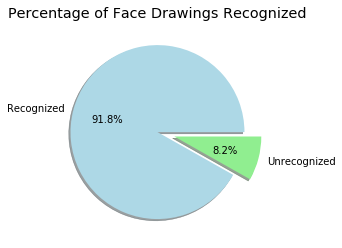

In [16]:
label = ('Recognized', 'Unrecognized')

plt.pie(face_df['recognized'].value_counts(),
        labels=label,
       explode=(0, 0.2),
       autopct= '%1.1f%%',
        shadow=True, 
       colors=('lightblue', 'lightgreen'))
plt.title('Percentage of Face Drawings Recognized');

plt.savefig('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/images/pie_face_drawings.png', bbox_inches='tight')

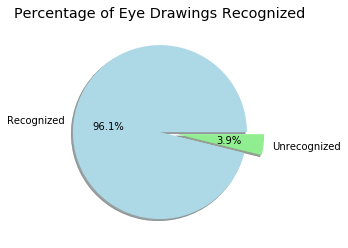

In [17]:
label = ('Recognized', 'Unrecognized')

plt.pie(eye_df['recognized'].value_counts(),
        labels=label,
       explode=(0, 0.2),
       autopct= '%1.1f%%',
        shadow=True, 
       colors=('lightblue', 'lightgreen'))
plt.title('Percentage of Eye Drawings Recognized');

plt.savefig('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/images/pie_eye_drawings.png', bbox_inches='tight')

In [42]:
# label = ('Recognized', 'Unrecognized')

# plt.pie(mouth_df['recognized'].value_counts(),
#         labels=label,
#        explode=(0, 0.2),
#        autopct= '%1.1f%%',
#         shadow=True, 
#        colors=('lightblue', 'lightgreen'))
# plt.title('Percentage of Mouth Drawings Recognized');

# plt.savefig('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/images/pie_mouth_drawings.png', bbox_inches='tight')

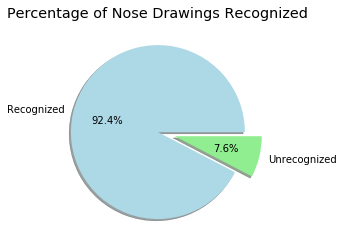

In [19]:
label = ('Recognized', 'Unrecognized')

plt.pie(nose_df['recognized'].value_counts(),
        labels=label,
       explode=(0, 0.2),
       autopct= '%1.1f%%',
        shadow=True, 
       colors=('lightblue', 'lightgreen'))
plt.title('Percentage of Nose Drawings Recognized');

plt.savefig('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/images/pie_nose_drawings.png', bbox_inches='tight')

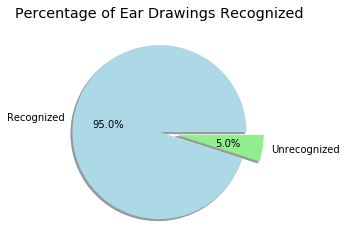

In [20]:
label = ('Recognized', 'Unrecognized')

plt.pie(ear_df['recognized'].value_counts(),
        labels=label,
       explode=(0, 0.2),
       autopct= '%1.1f%%',
        shadow=True, 
       colors=('lightblue', 'lightgreen'))
plt.title('Percentage of Ear Drawings Recognized');

plt.savefig('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/images/pie_ear_drawings.png', bbox_inches='tight')

# Prep the Models

In [12]:
# 0 = face | 1 = eye | 2 = nose | 3 = ear
X = df2
# y_dirty = df['word'].replace({'face': 0, 'eye': 1, 'mouth': 2, 'nose': 3})
y_dirty = df['word'].replace({'face': 0, 'eye': 1, 'nose': 2, 'ear': 3})
y = y_dirty.to_numpy()

In [14]:
y

array([0, 0, 0, ..., 3, 3, 3])

# Principle Component Analysis

### Why are we doing PCA?
We are doing PCA because each pixel that we have is considered one feature. If we put that into our models, that would result in a model that needs to account for 784 features (28 x 28). Not the most ideal scenario... So with PCA, we are able to lower the dimensionality of our data to more easily manage our predictions. 

### Finding the Ideal Number of Components

In [16]:
scaler = MinMaxScaler(feature_range=[0,1])
data_rescaled = scaler.fit_transform(X)
pca = PCA().fit(data_rescaled)

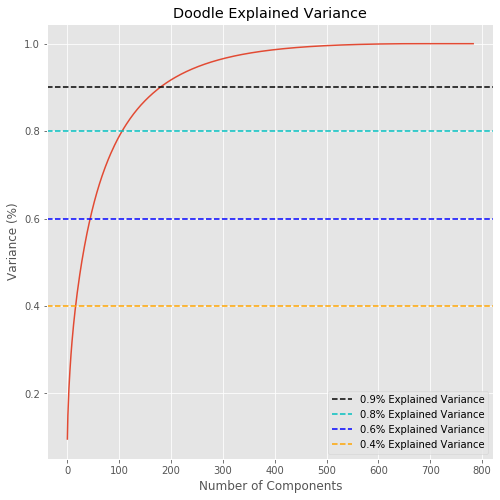

In [22]:
#Plotting the Cumulative Summation of the Explained Variance
var = [0.9, 0.8, 0.6, 0.4]
color = ['k', 'c', 'b', 'orange']
plt.figure(figsize=(8,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Doodle Explained Variance')
for i, j in zip(var, color):
    plt.axhline(y = i, color=j, linestyle='--', label = '{}% Explained Variance'.format(i))
plt.legend(loc='best')
plt.show()

In [23]:
def explainedVariance(percentage, images): 
    # percentage should be a decimal from 0 to 1 
    pca = PCA(percentage)
    pca.fit(images)
    components = pca.transform(images)
    approxOriginal = pca.inverse_transform(components)
    return approxOriginal

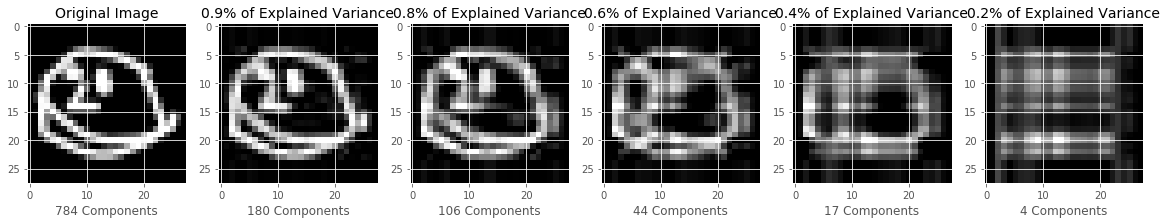

In [29]:
comp = [180, 106, 44, 17, 4]
var = [0.9, 0.8, 0.6, 0.4, 0.2]

# Original Image (784 components)
plt.figure(figsize=(20,6));
plt.subplot(1, 6, 1)
plt.imshow(df.npy[0].reshape(28,28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('784 Components', fontsize = 12)
plt.title('Original Image', fontsize = 14);

for i, j, k in zip(comp, var, range(2, 7)):
    plt.subplot(1, 6, k)
    plt.imshow(explainedVariance(j, df.npy[0].reshape(28, 28)),
                  cmap = plt.cm.gray, interpolation='nearest',
                  clim=(0, 255))
    plt.xlabel('{} Components'.format(i), fontsize = 12)
    plt.title('{}% of Explained Variance'.format(j), fontsize = 14);

### Plotting 2D Component PCA

In [34]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(2)
p_comp = pca.fit_transform(X)
p_df = pd.DataFrame(data = p_comp
             , columns = ['principal component 1', 'principal component 2'])
final_df = pd.concat([p_df, y_dirty], axis=1)

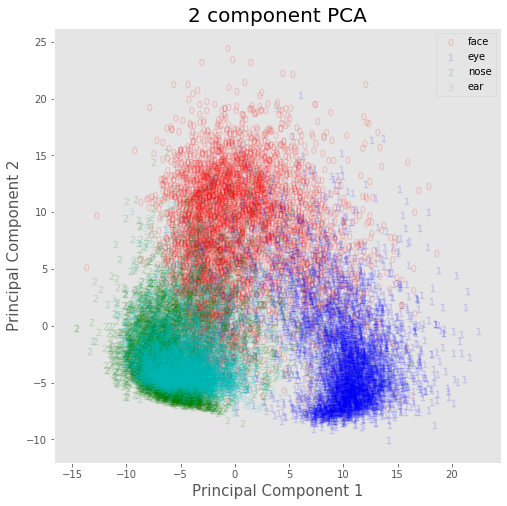

In [35]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0, 1]

ax.scatter(final_df['principal component 1'][:5000]
           , final_df['principal component 2'][:5000]
           , c = 'r'
           , s = 50
           , alpha=0.1
           , marker=('$0$'))
ax.scatter(final_df['principal component 1'][5000:10000]
           , final_df['principal component 2'][5000:10000]
           , c = 'b'
           , s = 50
           , alpha=0.1
           , marker=('$1$'))
ax.scatter(final_df['principal component 1'][10000:15000]
           , final_df['principal component 2'][10000:15000]
           , c = 'g'
           , s = 50
           , alpha=0.1
           , marker=('$2$'))
ax.scatter(final_df['principal component 1'][15000:]
           , final_df['principal component 2'][15000:]
           , c = 'c'
           , s = 50
           , alpha=0.1
           , marker=('$3$'))
ax.legend(['face', 'eye', 'nose', 'ear'])
ax.grid()

ax.figure.savefig('/Users/AaronLee/Documents/GalvanizeDSI/DoodlePredictor/images/two_comp_pca_1.png', bbox_inches='tight')

# 3d Principal Component

In [36]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(3)
p_comp = pca.fit_transform(X)
p_df = pd.DataFrame(data = p_comp
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
final_df = pd.concat([p_df, y_dirty], axis=1)

<IPython.core.display.Javascript object>


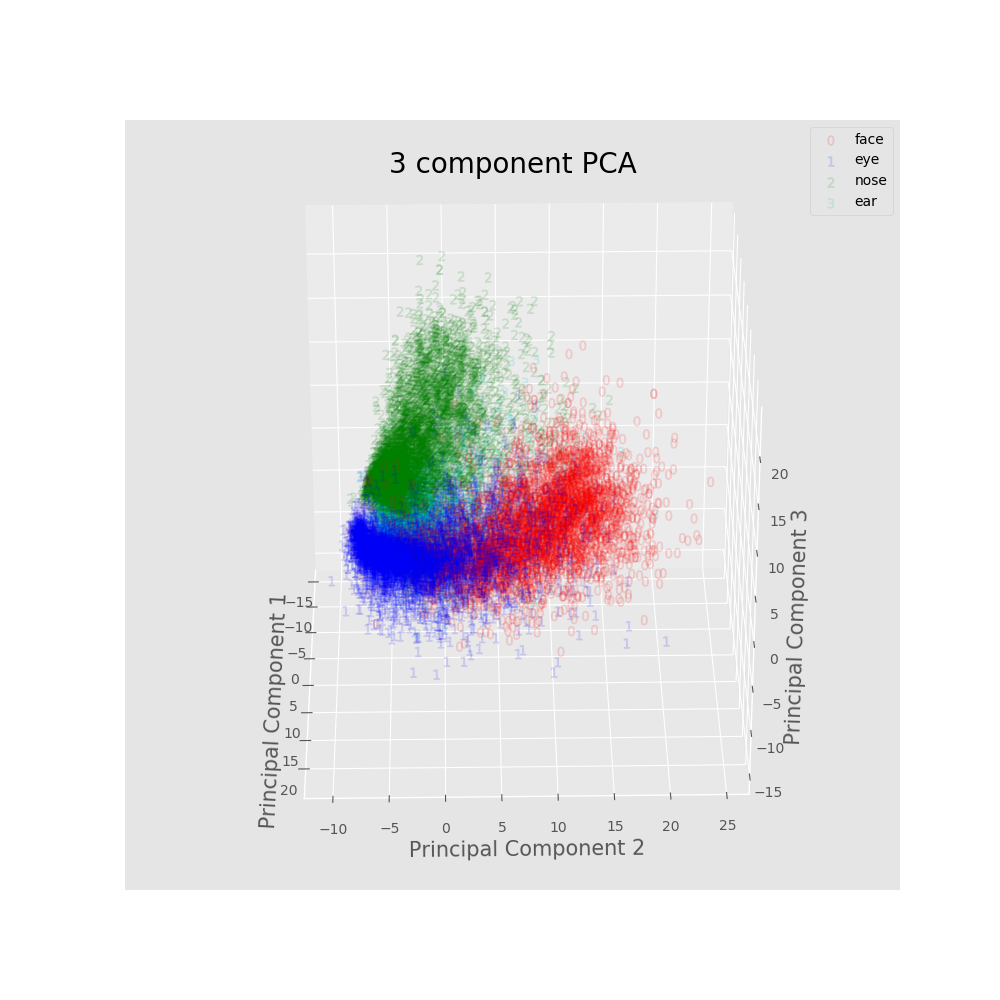

In [165]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)

ax.scatter3D(final_df['principal component 1'][:5000]
               , final_df['principal component 2'][:5000]
               , final_df['principal component 3'][:5000]
               , c = 'r'
               , s = 50
               , alpha=0.1
               , marker=('$0$'))
ax.scatter(final_df['principal component 1'][5000:10000]
           , final_df['principal component 2'][5000:10000]
           , final_df['principal component 3'][5000:10000]
           , c = 'b'
           , s = 50
           , alpha=0.1
           , marker=('$1$'))
ax.scatter(final_df['principal component 1'][10000:15000]
           , final_df['principal component 2'][10000:15000]
           , final_df['principal component 3'][10000:15000]
           , c = 'g'
           , s = 50
           , alpha=0.1
           , marker=('$2$'))
ax.scatter(final_df['principal component 1'][15000:]
           , final_df['principal component 2'][15000:]
           , final_df['principal component 3'][15000:]
           , c = 'c'
           , s = 50
           , alpha=0.1
           , marker=('$3$'))

ax.legend(['face', 'eye', 'nose', 'ear'])

for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

plt.show()

<IPython.core.display.Javascript object>


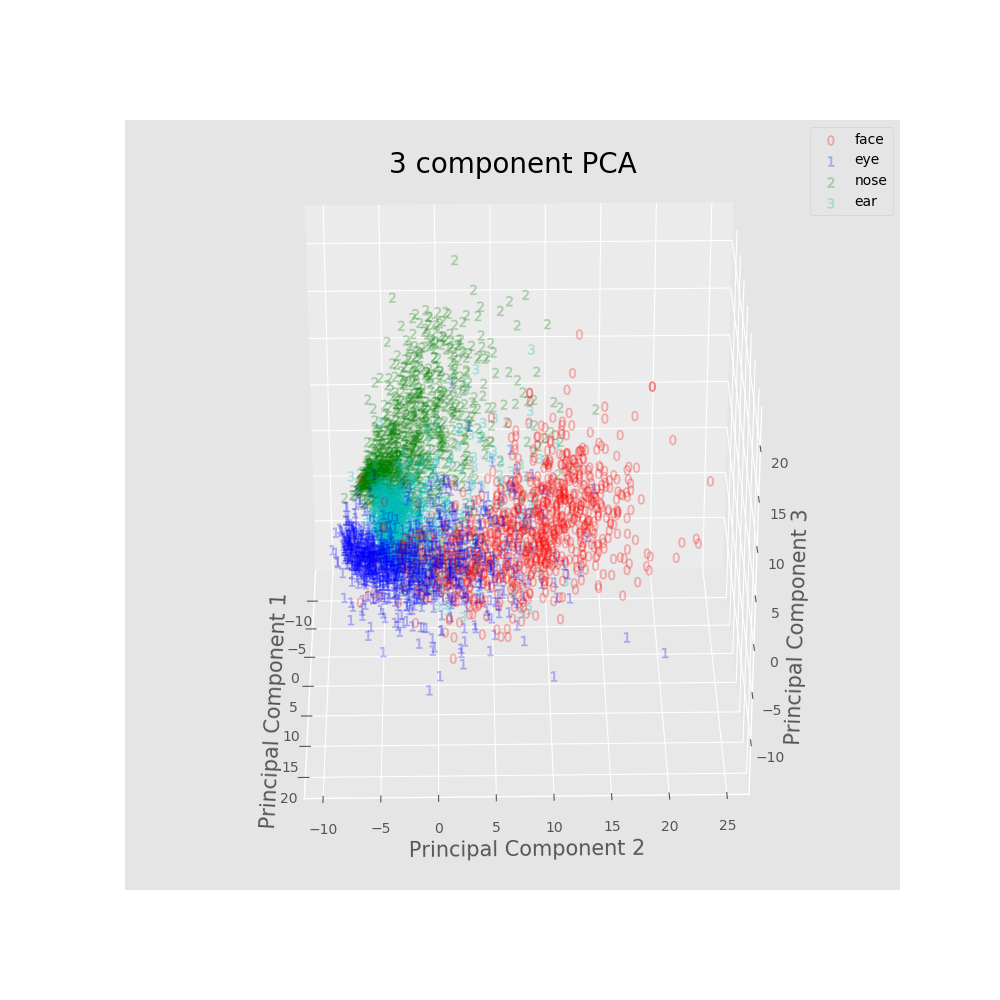

In [186]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)

ax.scatter3D(final_df['principal component 1'][:1000]
               , final_df['principal component 2'][:1000]
               , final_df['principal component 3'][:1000]
               , c = 'r'
               , s = 50
               , alpha=0.2
               , marker=('$0$'))
ax.scatter(final_df['principal component 1'][5000:6000]
           , final_df['principal component 2'][5000:6000]
           , final_df['principal component 3'][5000:6000]
           , c = 'b'
           , s = 50
           , alpha=0.2
           , marker=('$1$'))
ax.scatter(final_df['principal component 1'][10000:11000]
           , final_df['principal component 2'][10000:11000]
           , final_df['principal component 3'][10000:11000]
           , c = 'g'
           , s = 50
           , alpha=0.2
           , marker=('$2$'))
ax.scatter(final_df['principal component 1'][19000:]
           , final_df['principal component 2'][19000:]
           , final_df['principal component 3'][19000:]
           , c = 'c'
           , s = 50
           , alpha=0.2
           , marker=('$3$'))

ax.legend(['face', 'eye', 'nose', 'ear'])

for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

plt.show()

# Prep Data for Classifiers

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state=123, 
                                                   test_size=0.2)

In [32]:
scaler = StandardScaler()

# fit on training only
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# minimum number of principal components such that 95% of variance retained
# pca = PCA(0.90)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# Function to Test Different PCA Percentages

In [101]:
def pca_perc(X_train, X_test, y_train, y_test, model, perc):
    acc = []
    for i in perc:
        pca = PCA(i)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        
        model_func = model.fit(X_train, y_train)
        y_pred = model_func.predict(X_test)
        acc.append(model_func.score(X_test, y_test))
    return acc

### Logistic Regression Classifier

In [103]:
lrc = LogisticRegression(solver='lbfgs', multi_class='multinomial')
lrc_perc = [0.9, 0.8, 0.6, 0.4, 0.2]
lrc_acc = pca_perc(X_train, X_test, y_train, y_test, lrc, lrc_perc)
lrc_acc

# lrc_func = lrc.fit(X_train, y_train)

# # score_matrix(lrc_func)
# y_pred = lrc_func.predict(X_test)
# lrc_func.score(X_test, y_test)

/Users/AaronLee/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/AaronLee/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[0.913, 0.914, 0.9045, 0.854, 0.6165]

In [169]:
# print(classification_report(y_test, y_pred))

### Decision Tree Classifier

In [104]:
dtc = DecisionTreeClassifier()
dtc_perc = [0.9, 0.8, 0.6, 0.4, 0.2]
dtc_acc = pca_perc(X_train, X_test, y_train, y_test, dtc, dtc_perc)
dtc_acc

# dtc_func = dtc.fit(X_train, y_train)

# # score_matrix(dtc_func)
# y_pred = dtc_func.predict(X_test)
# dtc_func.score(X_test, y_test)

[0.8565, 0.855, 0.87125, 0.827, 0.52475]

### Random Forest Classifier

In [105]:
rfc = RandomForestClassifier()
rfc_perc = [0.9, 0.8, 0.6, 0.4, 0.2]
rfc_acc = pca_perc(X_train, X_test, y_train, y_test, rfc, rfc_perc)
rfc_acc

# rfc_func = rfc.fit(X_train, y_train)

# # score_matrix(rfc_func)
# y_pred = rfc_func.predict(X_test)
# rfc_func.score(X_test, y_test)

/Users/AaronLee/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.88425, 0.8955, 0.9055, 0.859, 0.53625]

### Gradient Boosting Classifier

In [107]:
gbc = GradientBoostingClassifier()
gbc_perc = [0.9, 0.8, 0.6, 0.4, 0.2]
gbc_acc = pca_perc(X_train, X_test, y_train, y_test, gbc, gbc_perc)
gbc_acc

# gbc_func = gbc.fit(X_train, y_train)

# # score_matrix(gbc_func)
# y_pred = gbc_func.predict(X_test)
# gbc_func.score(X_test, y_test)

[0.9115, 0.91425, 0.909, 0.86475, 0.6125]

### Support Vector Machine (linear and rbf)

In [108]:
svc = SVC()
svc_perc = [0.9, 0.8, 0.6, 0.4, 0.2]
svc_acc = pca_perc(X_train, X_test, y_train, y_test, svc, svc_perc)
svc_acc

# svc_func = svc.fit(X_train, y_train)

# # score_matrix(svc_func)
# y_pred = svc_func.predict(X_test)
# svc_func.score(X_test, y_test)

/Users/AaronLee/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/AaronLee/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/AaronLee/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/AaronLee/anaconda3/lib/python3.7/site-p

[0.9115, 0.8535, 0.8125, 0.8665, 0.6185]

### Total Scores

In [111]:
print('Logistic Regression: {}'.format(lrc_acc))
print('Decision Tree: {}'.format(dtc_acc))
print('Random Forest: {}'.format(rfc_acc))
print('Gradient Boosting: {}'.format(gbc_acc))
print('Support Vector Machine: {}'.format(svc_acc))

Logistic Regression: [0.913, 0.914, 0.9045, 0.854, 0.6165]
Decision Tree: [0.8565, 0.855, 0.87125, 0.827, 0.52475]
Random Forest: [0.88425, 0.8955, 0.9055, 0.859, 0.53625]
Gradient Boosting: [0.9115, 0.91425, 0.909, 0.86475, 0.6125]
Support Vector Machine: [0.9115, 0.8535, 0.8125, 0.8665, 0.6185]


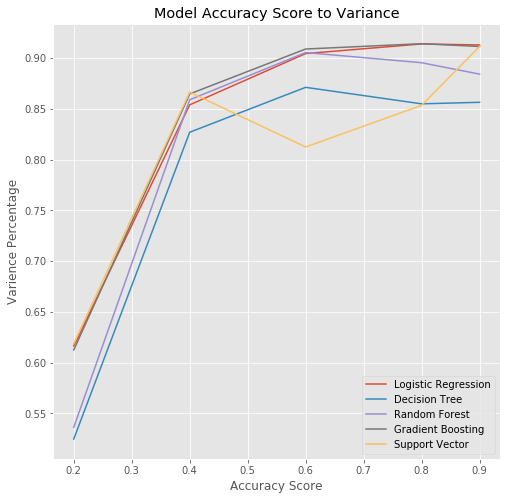

In [126]:
# plotting models
plt.figure(figsize=(8,8))
plt.plot(lrc_perc, lrc_acc, label='Logistic Regression')
plt.plot(dtc_perc, dtc_acc, label='Decision Tree')
plt.plot(rfc_perc, rfc_acc, label='Random Forest')
plt.plot(gbc_perc, gbc_acc, label='Gradient Boosting')
plt.plot(svc_perc, svc_acc, label='Support Vector')
plt.ylabel('Varience Percentage')
plt.xlabel('Accuracy Score')
plt.title('Model Accuracy Score to Variance')
plt.legend(loc='best');

# Optimizing Models w/ Varience held at 90% ~ 180 PC

Decided to drop Logistic Regression because there's not much to optomize and I am not focusing on which specific features to highlight in my model. Gradient Boosting and Support Vector topped out at ~91% accuracy with 90% varience so I will explore optimizing those 2 models through grid searching.

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state=123, 
                                                   test_size=0.2)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(0.90)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [172]:
lrc = LogisticRegression(solver='lbfgs', multi_class='multinomial')
lrc_func = lrc.fit(X_train, y_train)

y_pred = lrc_func.predict(X_test)
print ('Logistic Regression Classifier')
print(classification_report(y_test, y_pred))

Logistic Regression Classifier
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       990
           1       0.92      0.92      0.92       995
           2       0.94      0.95      0.94      1004
           3       0.90      0.90      0.90      1011

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



/Users/AaronLee/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [174]:
dtc = DecisionTreeClassifier()
dtc_func = dtc.fit(X_train, y_train)

y_pred = dtc_func.predict(X_test)
print ('Decision Tree Classifier')
print(classification_report(y_test, y_pred))

Decision Tree Classifier
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       990
           1       0.89      0.88      0.89       995
           2       0.87      0.89      0.88      1004
           3       0.84      0.83      0.83      1011

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



In [175]:
rfc = RandomForestClassifier()
rfc_func = rfc.fit(X_train, y_train)

y_pred = rfc_func.predict(X_test)
print ('Random Forest Classifier')
print(classification_report(y_test, y_pred))

/Users/AaronLee/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Classifier
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       990
           1       0.92      0.89      0.90       995
           2       0.91      0.90      0.90      1004
           3       0.91      0.83      0.87      1011

    accuracy                           0.87      4000
   macro avg       0.88      0.87      0.87      4000
weighted avg       0.88      0.87      0.87      4000



In [176]:
gbc = GradientBoostingClassifier()
gbc_func = gbc.fit(X_train, y_train)

y_pred = gbc_func.predict(X_test)
print ('Gradient Boosting Classifier')
print(classification_report(y_test, y_pred))

Gradient Boosting Classifier
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       990
           1       0.93      0.93      0.93       995
           2       0.93      0.94      0.94      1004
           3       0.92      0.88      0.90      1011

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



In [177]:
svc = SVC()
svc_func = svc.fit(X_train, y_train)


y_pred = svc_func.predict(X_test)
print ('Support Vector Classifier')
print(classification_report(y_test, y_pred))

/Users/AaronLee/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Support Vector Classifier
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       990
           1       0.96      0.91      0.94       995
           2       0.98      0.89      0.93      1004
           3       0.95      0.89      0.92      1011

    accuracy                           0.91      4000
   macro avg       0.92      0.91      0.91      4000
weighted avg       0.92      0.91      0.91      4000



### Grid Search

##### Gradient Boosting

In [135]:
param_grid = [
    {'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [10, 100, 200], 'subsample': [1],
    }
]
gbc_gs = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, 
                     cv=3)
gbc_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [137]:
gbc_gs.best_params_

{'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 1}

In [147]:
# gbc_gs.cv_results_

In [143]:
gbc = GradientBoostingClassifier(learning_rate= 0.1, n_estimators= 200, subsample= 1)
gbc_func = gbc.fit(X_train, y_train)

# # score_matrix(gbc_func)
y_pred = gbc_func.predict(X_test)
gbc_func.score(X_test, y_test)

0.9185

##### Support Vector

In [182]:
param_grid = [
    {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}
]
svc_gs = GridSearchCV(SVC(), param_grid=param_grid)
svc_gs.fit(X_train, y_train)

/Users/AaronLee/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [188]:
svc_gs.best_params_

{'C': 10, 'gamma': 0.001}

## Retuned Hyper-Parameters

In [189]:
gbc = GradientBoostingClassifier(learning_rate= 0.1, n_estimators= 200, subsample= 1)
gbc_func = gbc.fit(X_train, y_train)

y_pred = gbc_func.predict(X_test)
print ('Gradient Boosting Classifier')
print(classification_report(y_test, y_pred))

Gradient Boosting Classifier
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       990
           1       0.94      0.94      0.94       995
           2       0.94      0.95      0.94      1004
           3       0.92      0.89      0.91      1011

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000



In [33]:
def some_model(X_train, X_test, y_train, y_test, model):
    clf = model()
    clf_func = clf.fit(X_train, y_train)

    y_pred = clf_func.predict(X_test)
    print(model)
    print(classification_report(y_test, y_pred))

In [35]:
# some_model(X_train, X_test, y_train, y_test, GradientBoostingClassifier)

In [190]:
svc = SVC(C=10, gamma=0.001)
svc_func = svc.fit(X_train, y_train)


y_pred = svc_func.predict(X_test)
print ('Support Vector Classifier')
print(classification_report(y_test, y_pred))

Support Vector Classifier
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       990
           1       0.96      0.95      0.96       995
           2       0.96      0.95      0.96      1004
           3       0.94      0.93      0.94      1011

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



### Neural Networks

In [193]:
# Prep the data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state=123, 
                                                   test_size=0.2)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(0.90)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)